In [100]:
import pandas as pd
import yaml
from PIL import Image
import numpy
from torchvision import transforms
import sys
import matplotlib.pyplot as plt
import math

sys.path.append('../')

from train import create_dataloader, load_model
from dataset import MDclassDataset

import torch

In [101]:
split_name = "frac0.01_split0.4"
dat_train = pd.read_csv(f"~/Documents/cv4e/CV4E-2025/data/tabular/splits/{split_name}/dat_train.csv")
dat_val = pd.read_csv(f"~/Documents/cv4e/CV4E-2025/data/tabular/splits/{split_name}/dat_val.csv")
dat_test = pd.read_csv(f"~/Documents/cv4e/CV4E-2025/data/tabular/splits/{split_name}/dat_test.csv")

lookup = pd.read_csv("~/Documents/cv4e/CV4E-2025/data/tabular/labels_lookup.csv")

cfg = yaml.safe_load(open("../configs/resnet101.yaml", "r"))

In [102]:
all_dat = pd.read_csv("~/Documents/cv4e/CV4E-2025/data-raw/tabular/bbox_data_crop_all.csv")

/tmp/ipykernel_648725/919887652.py:1: DtypeWarning: Columns (1,3,5,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  all_dat = pd.read_csv("~/Documents/cv4e/CV4E-2025/data-raw/tabular/bbox_data_crop_all.csv")


In [103]:
sum([math.isnan(x) for x in all_dat.confidence])

56094

In [104]:
n_class = dat_train.label_id.nunique()
n_class

20

In [105]:
cfg

{'model_name': 'resnet101',
 'seed': 32678456782,
 'device': 'cuda',
 'num_workers': 16,
 'basepath': '/mnt/class_data/group4/val/trailcam/',
 'train_val_split': 0.4,
 'data_frac': 0.01,
 'image_size': [256, 256],
 'num_epochs': 100,
 'batch_size': 64,
 'learning_rate': 0.1,
 'weight_decay': 0}

In [106]:
!pwd

/home/Vale/Documents/cv4e/CV4E-2025/mdclassifier


In [107]:


dl_train = create_dataloader(cfg, dat_train.crop_path, dat_train.label_id, split="train", model="resnet101")

In [108]:
instance=next(iter(dl_train))

In [109]:
instance.keys()

dict_keys(['image_id', 'image', 'label'])

In [110]:
ims = [instance["image"][x] for x in range(len(instance["image"]))]
labs = [instance["label"][x] for x in range(len(instance["label"]))]
labs = [lookup.query(f'label_id == {x}').iloc[0,0] for x in [x.numpy() for x in labs]]

In [111]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

ims = [invTrans(ims[x]) for x in range(len(ims))]
ims

[tensor([[[0.0863, 0.0902, 0.0941,  ..., 0.1255, 0.1216, 0.1255],
          [0.0941, 0.0941, 0.0980,  ..., 0.1176, 0.1137, 0.1176],
          [0.1020, 0.0980, 0.0980,  ..., 0.1137, 0.1098, 0.1137],
          ...,
          [0.1529, 0.1373, 0.1412,  ..., 0.2471, 0.2157, 0.1882],
          [0.1569, 0.1412, 0.1451,  ..., 0.2275, 0.1843, 0.1569],
          [0.1569, 0.1412, 0.1451,  ..., 0.2157, 0.1725, 0.1451]],
 
         [[0.0863, 0.0902, 0.0941,  ..., 0.1255, 0.1216, 0.1255],
          [0.0941, 0.0941, 0.0980,  ..., 0.1176, 0.1137, 0.1176],
          [0.1020, 0.0980, 0.0980,  ..., 0.1137, 0.1098, 0.1137],
          ...,
          [0.1529, 0.1373, 0.1412,  ..., 0.2471, 0.2157, 0.1882],
          [0.1569, 0.1412, 0.1451,  ..., 0.2275, 0.1843, 0.1569],
          [0.1569, 0.1412, 0.1451,  ..., 0.2157, 0.1725, 0.1451]],
 
         [[0.0863, 0.0902, 0.0941,  ..., 0.1255, 0.1216, 0.1255],
          [0.0941, 0.0941, 0.0980,  ..., 0.1176, 0.1137, 0.1176],
          [0.1020, 0.0980, 0.0980,  ...,

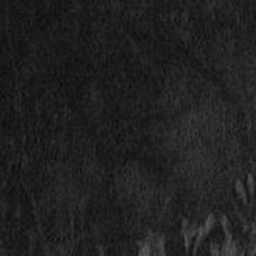

In [112]:
Image.fromarray((255*numpy.transpose(ims[0].numpy(), (1,2,0))).astype(numpy.uint8))

In [113]:
ims_pil = [Image.fromarray((255*numpy.transpose(ims[x].numpy(), (1,2,0))).astype(numpy.uint8)) for x in range(len(ims))]

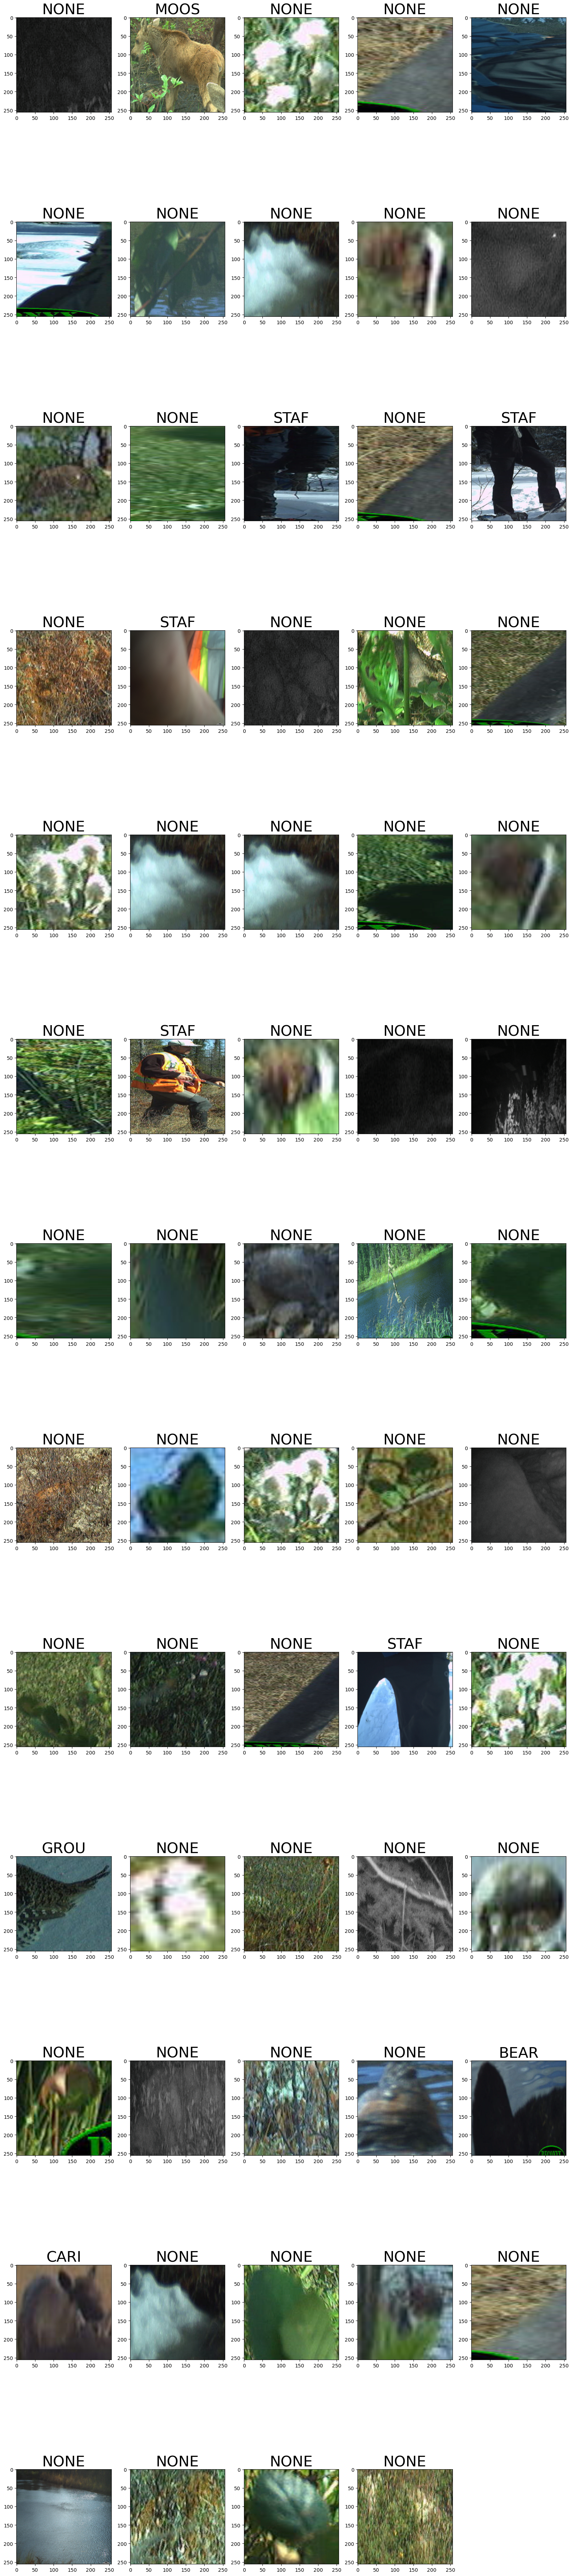

In [114]:
import textwrap
def display_images(
    images, labs,
    columns=5, width=20, height=8, max_images=1000000, 
    label_wrap_length=50, label_font_size=30):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        title=textwrap.wrap(labs[i], label_wrap_length)
        title="\n".join(title)
        plt.title(title, fontsize=label_font_size); 

display_images(ims_pil, labs)

In [115]:
# IDEA 1: REMOVE LOW CONFIDENCE NONE IMAGES => THESE ARE LOW QUALITY EXAMPLES WE MIGHT NOT EVEN CONSIDER
# IDEA 2: Weight loss from MD score

In [116]:
state = torch.load(
            open("/home/Vale/Documents/cv4e/CV4E-2025/runs/resnet101_100e_64bs_0.1lr_0wd_frac0.01_split0.4/50.pt", "rb"), map_location="cpu", 
            weights_only=True
        )

In [117]:
model = load_model(cfg, n_class)[0]
model.load_state_dict(state["model"])
# model

Starting new model


<All keys matched successfully>

In [118]:
preds = model(instance["image"])
preds

tensor([[  -0.2548,   -1.1706,    2.8895,  ...,   -4.2999,    0.6279,
           -2.8256],
        [  -0.2548,   -1.1706,    2.8895,  ...,   -4.2999,    0.6279,
           -2.8256],
        [  34.7220, -160.5090,  104.9343,  ..., -187.3448,   29.7878,
         -120.4249],
        ...,
        [  -0.2548,   -1.1706,    2.8895,  ...,   -4.2999,    0.6279,
           -2.8256],
        [  -0.2548,   -1.1706,    2.8895,  ...,   -4.2999,    0.6279,
           -2.8256],
        [  -0.2548,   -1.1706,    2.8895,  ...,   -4.2999,    0.6279,
           -2.8256]], grad_fn=<AddmmBackward0>)

In [119]:
preds.argmax(axis=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
####